In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import six

sns.set(style='ticks', context='paper', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline


folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_modalities'

import flotilla

flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects'
study = flotilla.embark('singlecell_pnm_figure2_modalities_bayesian', flotilla_dir=flotilla_dir)
not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)

psi = study.splicing.singles.ix[not_outliers]
grouped = psi.groupby(study.sample_id_to_phenotype)
psi_filtered = grouped.apply(lambda x: x.dropna(axis=1, thresh=20))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-02-10 09:56:41	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities_bayesian/datapackage.json
2016-02-10 09:56:41	Parsing datapackage to create a Study object
2016-02-10 09:57:25	Initializing Study
2016-02-10 09:57:25	Initializing Predictor configuration manager for Study
2016-02-10 09:57:25	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-02-10 09:57:25	Added ExtraTreesClassifier to default predictors
2016-02-10 09:57:25	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-02-10 09:57:25	Added ExtraTreesRegressor to default predictors
2016-02-10 09:57:25	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-02-10 09:57:25	Added GradientBoostingClassifier to default predic

### Enrichment of this modality, within phenotype

i.e. *"What GO categories are iPSC bimodal events enriched for, compared to other modalities in iPSC?"*

In [4]:
figure_folder = '{}/gene_ontology'.format(folder)
! mkdir $figure_folder

In [5]:
study.splicing.feature_expression_id_col = 'ensembl_id'

In [21]:
np.finfo(np.float128).eps

1.084202172485504434e-19

MN
	ambivalent
... empty GO enrichment!
	bimodal
	excluded
	included
NPC
	ambivalent
... empty GO enrichment!
	bimodal
	excluded
	included
iPSC
	ambivalent
	bimodal
	concurrent
... empty GO enrichment!
	excluded
	included


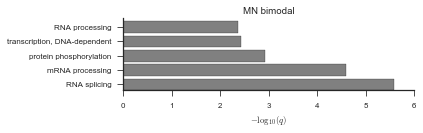

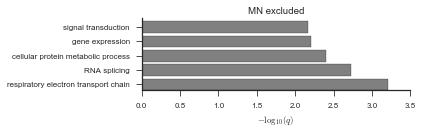

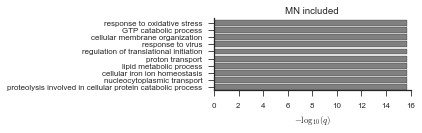

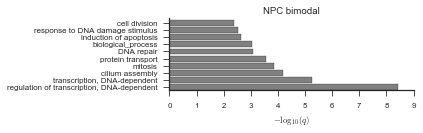

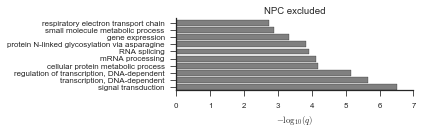

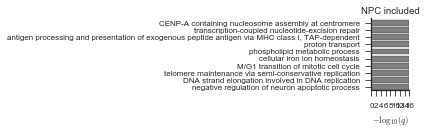

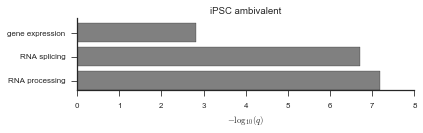

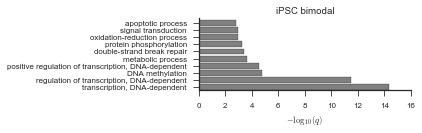

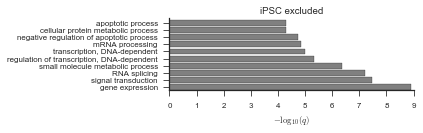

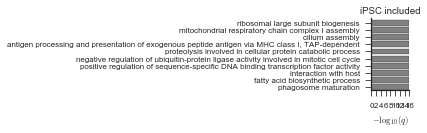

In [16]:
from flotilla.visualize.gene_ontology import plot_go_enrichment
gos = []
for (phenotype), phenotype_df in study.supplemental.modalities_tidy.groupby(['phenotype']):
    print phenotype
    background = study.splicing.splicing_to_expression_id(phenotype_df.event_name)
    for modality, modality_df in phenotype_df.groupby('modality'):
        print '\t', modality
        modality_genes = study.splicing.splicing_to_expression_id(modality_df.event_name)
        go = study.go_enrichment(modality_genes, background, p_value_cutoff=0.01, 
                                 min_feature_size=5, min_background_size=10,
                                 domain='biological_process')
        if go is None or go.empty:
            print '... empty GO enrichment!'
            continue
        fig, ax = plt.subplots(figsize=(6, 2))
        ax = plot_go_enrichment(data=go, color='grey')
        ax.set_title('{} {}'.format(phenotype, modality))
        fig = plt.gcf()
        fig.tight_layout()
        fig.savefig('{}/modality_go_enrichment_within_celltype_{}_{}.pdf'.format(figure_folder, modality, phenotype))

### Enrichment of this modality, across phenotypes

i.e. *"What GO categories are iPSC bimodal events enriched for, compared to bimodal events in NPC and MN?"*

ambivalent
	MN
	... empty GO enrichment!
	NPC
	... empty GO enrichment!
	iPSC
bimodal
	MN
	NPC
	iPSC
concurrent
	iPSC
	... empty GO enrichment!
excluded
	MN
	NPC
	iPSC
included
	MN
	NPC
	iPSC


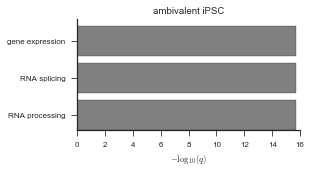

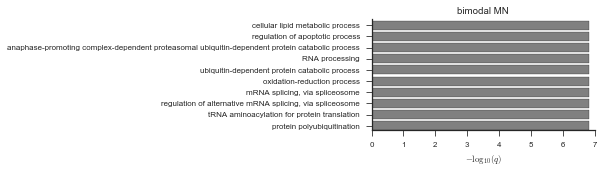

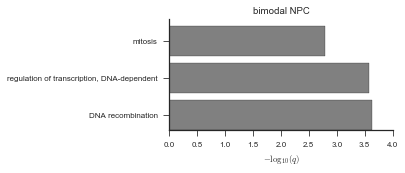

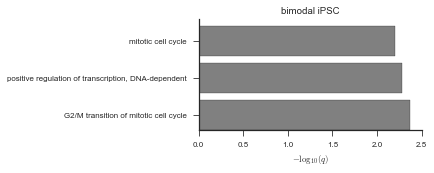

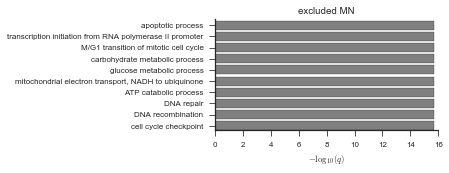

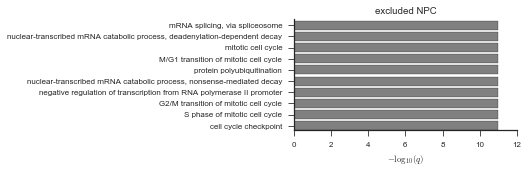

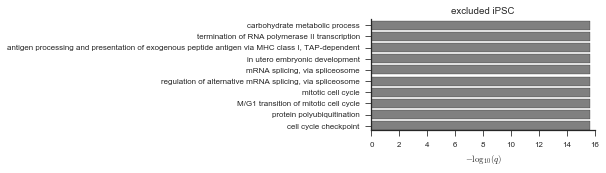

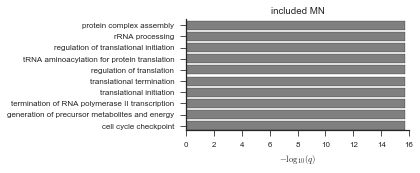

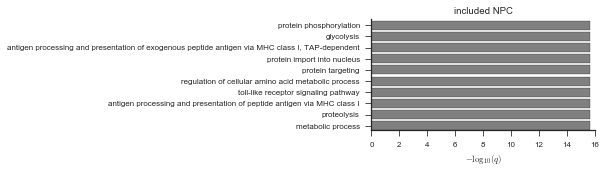

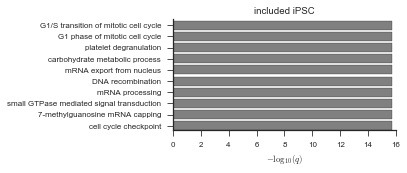

In [25]:
import itertools

modalities_all_celltypes = study.supplemental.modalities_tidy.groupby('event_name').filter(
    lambda x: len(x)==len(study.phenotype_order))

go_dfs = []

for (phenotype), phenotype_df in modalities_all_celltypes.groupby(['modality']):
    print phenotype
    background = study.splicing.splicing_to_expression_id(phenotype_df.event_name)
    for modality, modality_df in phenotype_df.groupby('phenotype'):
        print '\t', modality
        modality_genes = study.splicing.splicing_to_expression_id(modality_df.event_name)
        go = study.go_enrichment(modality_genes, background, p_value_cutoff=0.01, 
#                                  min_feature_size=5, min_background_size=10,
                                domain='biological_process')
        if go is None or go.empty:
            print '\t... empty GO enrichment!'
            continue
            
        go['modality'] = modality
        go['phenotype'] = phenotype
        go_dfs.append(go.reset_index())
        fig, ax = plt.subplots(figsize=(4, 2))
        ax = plot_go_enrichment(data=go, color='grey')
        ax.set_title('{} {}'.format(phenotype, modality))
        fig = plt.gcf()
#         fig.tight_layout()
        fig.savefig('{}/modality_go_enrichment_across_celltypes_{}_{}.pdf'.format(figure_folder, modality, phenotype))
go_df = pd.concat(go_dfs, ignore_index=True)

### Enrichment of this modality vs all other modalities across phenotypes

i.e. *"What GO categories are bimodal events in iPSC, NPC and MN enriched for, over other modalities in those celltypes?"*

In [23]:
modalities_all_celltypes = study.supplemental.modalities_tidy.groupby('event_name').filter(
    lambda x: len(x) == len(study.phenotype_order))

ambivalent
bimodal
concurrent
	... empty GO enrichment!
excluded
included


ValueError: left cannot be >= right

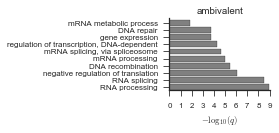

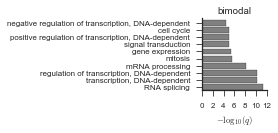

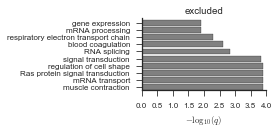

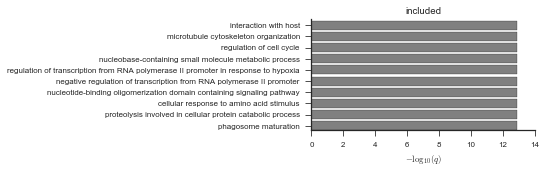

In [26]:
import itertools

background = study.splicing.splicing_to_expression_id(modalities_all_celltypes.event_name)


for (group), df1 in modalities_all_celltypes.groupby(['modality']):
    print group
    foreground = study.splicing.splicing_to_expression_id(df1.event_name)
    go = study.go_enrichment(foreground, background, p_value_cutoff=0.1, 
#                              min_feature_size=5, min_background_size=10,
                             domain='biological_process')
    if go is None or go.empty:
        print '\t... empty GO enrichment!'
        continue

    fig, ax = plt.subplots(figsize=(4, 2))
    ax = plot_go_enrichment(data=go, color='grey')
    ax.set_title(group)
    fig = plt.gcf()
    fig.tight_layout()
    fig.savefig('{}/modality_go_enrichment_across_celltypes_{}.pdf'.format(figure_folder, group))